# Part 2

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html)

> 1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.


In [23]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

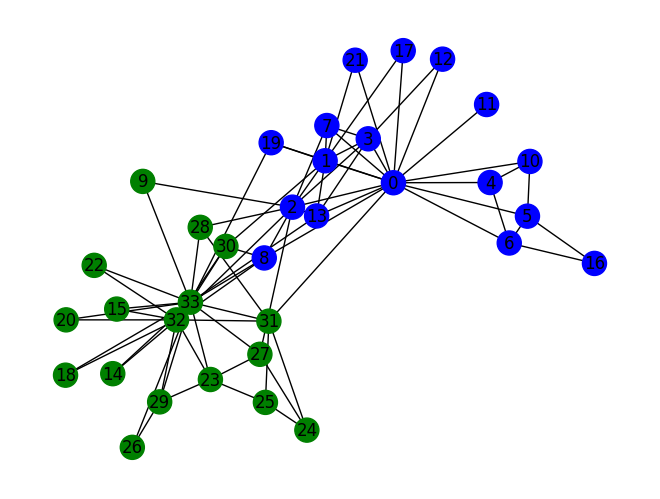

In [12]:
color = nx.get_node_attributes(G, "club")
color

color_map = []
for node in range(len(G)):
    if color[node] == 'Mr. Hi':
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()



> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.


In [13]:
from collections import defaultdict

def modularity(G, partition): 
    '''
    n_c = partitioning
    G = graph
    
    '''
    L = G.size(weight='weight')  # total weight of all edges

    # Organize nodes by community
    community_dict = defaultdict(set)
    for node, comm in nx.get_node_attributes(G, "club").items():
        community_dict[comm].add(node)

    modularity = 0.0

    for community_nodes in community_dict.values():
            subgraph = G.subgraph(community_nodes)

            L_c = subgraph.size(weight='weight')  # Total internal edge weight in community
            k_c = sum(G.degree(n, weight='weight') for n in community_nodes)  # Sum of degrees of nodes in community

            modularity += (L_c / L) - ((k_c / (2 * L)) ** 2)

    return modularity



> 3. Explain in your own words the concept of _modularity_.



> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.


In [14]:
modularity_original_value = modularity(G,"club")
modularity_original_value

0.39143756676224206


> 5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.


In [15]:
import random
import itertools

def double_edge_swap_2(G, num_swaps_multiplier=10):

   # Create a deep copy of the graph
    G_copy = G.copy()
    G_copy = G_copy.to_undirected()

    E = len(G_copy.edges())
    nodes = list(itertools.chain(*list(G_copy.edges())))
    num_swaps = E * num_swaps_multiplier  # Total swaps to perform

    for _ in range(num_swaps): 
        x,u = random.sample(nodes,2)
        v = random.choice(list(G[u]))
        y = random.choice(list(G[x]))

        if u != y and x != v and (u, y) not in G_copy.edges() and (x, v) not in G_copy.edges():
            if (x,y) in G_copy.edges() and (u,v) in G_copy.edges(): 
            # Remove old edges safely 
                G_copy.remove_edge(u, v)
                G_copy.remove_edge(x, y)

                # Add new edges
                G_copy.add_edge(u, y)
                G_copy.add_edge(x, v)

    return G_copy

In [16]:
from tqdm import tqdm

modularity_values = []

for _ in tqdm(range(100)): 
    G_randomized = double_edge_swap_2(G)
    modularity_value = modularity(G_randomized, "club")
    modularity_values.append(modularity_value)

 12%|█▏        | 12/100 [00:00<00:00, 108.37it/s]

100%|██████████| 100/100 [00:00<00:00, 129.40it/s]



> 6. Compute the average and standard deviation of the modularity for the random network.


In [17]:
import statistics

mean = statistics.mean(modularity_values)
std = statistics.stdev(modularity_values)

mean,std

(0.021000163081719758, 0.052737260330992665)


> 7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)).


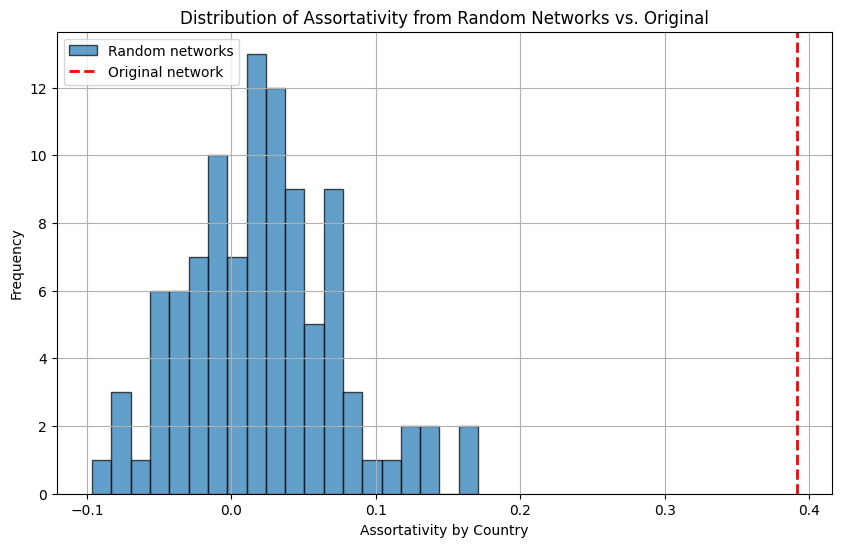

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(modularity_values, bins=20, edgecolor='black', alpha=0.7, label='Random networks')
plt.axvline(modularity_original_value, color='red', linestyle='--', linewidth=2, label='Original network')
plt.xlabel("Assortativity by Country")
plt.ylabel("Frequency")
plt.title("Distribution of Assortativity from Random Networks vs. Original")
plt.legend()
plt.grid(True)
plt.show()


> 8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?



> 9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?


In [21]:
import networkx as nx
import community as community_louvain  # from python-louvain package
from collections import defaultdict

# Run Louvain algorithm
partition_louvain = community_louvain.best_partition(G)

community_groups = defaultdict(set)
for node, comm_id in partition_louvain.items():
    community_groups[comm_id].add(node)

partition_sets = list(community_groups.values())

# Compute modularity
mod_louvain = modularity(G, partition_sets)

print("Louvain Modularity:", mod_louvain)

Louvain Modularity: 0.39143756676224206



> 10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [45]:
import networkx as nx
import community as community_louvain  # pip install python-louvain
import numpy as np

# Run Louvain community detection
partition = community_louvain.best_partition(G)

# Map of node to Louvain community
louvain_labels = list(partition.values())
communities = set(louvain_labels)
A = len(communities)

# Create confusion matrix D
D = np.zeros((A, 2), dtype=int)

for node in G.nodes():
    louvain_comm = partition[node]
    club_group = 0 if G.nodes[node]['club'] == 'Mr. Hi' else 1
    D[louvain_comm, club_group] += 1

print("Confusion matrix D:")
print(D)

Confusion matrix D:
[[11  0]
 [ 1 13]
 [ 5  0]
 [ 0  4]]


Row 0: Louvain community 0 has 11 nodes, all from club 0 (Mr. Hi).

Row 1: Louvain community 1 has 14 nodes — 1 from club 0, 13 from club 1 (mostly Officer).

Row 2: Louvain community 2 has 5 nodes, all from club 0 (Mr. Hi).

Row 3: Louvain community 3 has 4 nodes, all from club 1 (Officer).

